In [74]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

# Data Loading

We will use the doors dataset we already cleaned up to train our model.

Only cropped images are used in the training set. We apply different transformations to the images to improve the performance of the model.

For training, we apply `RandomResizedCrop` to the images, and `RandomHorizontalFlip` to the images. For validation and testing, we apply `Resize` and `CenterCrop` to the images.
Then, we convert the images to tensors and normalize them. Note that the normalization is the same for training, validation and testing.

In [75]:
# Data transformations and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/cropped'
image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x), data_transforms[x]
    ) 
    for x in ['train', 'val','test']
}
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=4, shuffle=True, num_workers=4
    ) 
    for x in ['train', 'val', 'test']
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Set the device

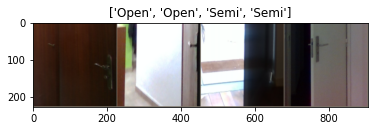

In [76]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [77]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            history[f"{phase}_loss"].append(epoch_loss)
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            history[f"{phase}_acc"].append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [78]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [79]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [80]:
model_ft, history = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=12)

Epoch 0/11
----------
train Loss: 1.1281 Acc: 0.4567
val Loss: 0.7884 Acc: 0.6000

Epoch 1/11
----------
train Loss: 1.0384 Acc: 0.5403
val Loss: 1.3990 Acc: 0.6333

Epoch 2/11
----------
train Loss: 1.1314 Acc: 0.5672
val Loss: 0.8527 Acc: 0.6333

Epoch 3/11
----------
train Loss: 1.1300 Acc: 0.5522
val Loss: 0.7049 Acc: 0.6833

Epoch 4/11
----------
train Loss: 0.9115 Acc: 0.6358
val Loss: 0.8426 Acc: 0.6500

Epoch 5/11
----------
train Loss: 1.0017 Acc: 0.5761
val Loss: 0.9975 Acc: 0.6333

Epoch 6/11
----------
train Loss: 1.0765 Acc: 0.6388
val Loss: 0.5430 Acc: 0.7833

Epoch 7/11
----------
train Loss: 0.7537 Acc: 0.6716
val Loss: 0.3403 Acc: 0.9000

Epoch 8/11
----------
train Loss: 0.6751 Acc: 0.7313
val Loss: 0.2901 Acc: 0.9000

Epoch 9/11
----------
train Loss: 0.6073 Acc: 0.7373
val Loss: 0.3198 Acc: 0.8667

Epoch 10/11
----------
train Loss: 0.6702 Acc: 0.7284
val Loss: 0.2725 Acc: 0.8833

Epoch 11/11
----------
train Loss: 0.6400 Acc: 0.7433
val Loss: 0.2553 Acc: 0.9167

Tr

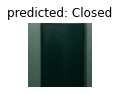

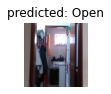

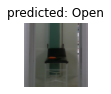

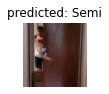

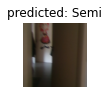

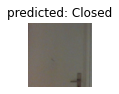

In [81]:
visualize_model(model_ft)

In [82]:
def plots(history, key):
    loss = history[f"{key}_loss"]
    acc = history[f"{key}_acc"]
    plt.plot(loss, "-rx", label="loss")
    plt.plot(acc, "-bx", label="acc")
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.legend([f"{key}_loss", f"{key}_acc"])
    plt.show()

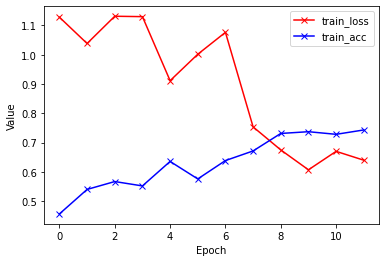

In [83]:
plots(history, "train")

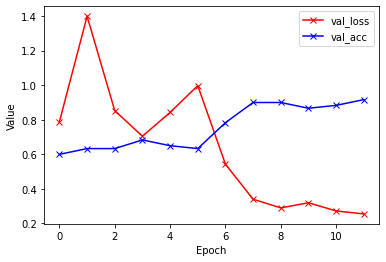

In [84]:
plots(history, "val")

In [85]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def conf_matrix(model, dataloader, device):
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.data.cpu().numpy())
            y_pred.extend(preds.data.cpu().numpy())
        
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d")

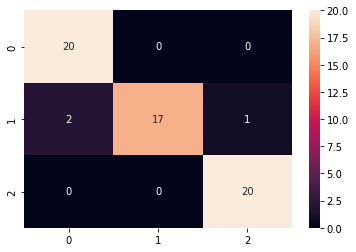

In [86]:
conf_matrix(model_ft, dataloaders["test"], device)

In [87]:
torch.save(model_ft.state_dict(), f"models/finetuning.pt")

In [88]:
torch.save(model_ft.state_dict(), "models/finetuning.bin")